<a href="https://colab.research.google.com/github/Akzhan3001/Python-projects/blob/main/Parkinson_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostRegressor

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

In [ ]:
df = pd.read_csv('./parkinson_sample.csv')

## **Exploratory Data Analysis**

In [ ]:
df.head(5)


,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,25.647,35.810,0.00340,0.000021,0.00178,0.00162,0.00533,...,0.157,0.00711,0.00765,0.00926,0.02132,0.016636,25.986,0.42271,0.56963,0.11774
1,1,72,0,75.657,39.340,0.00285,0.000013,0.00109,0.00136,0.00327,...,0.089,0.00456,0.00584,0.00937,0.01367,0.004981,27.984,0.35842,0.52350,0.17555
2,1,72,0,68.688,38.849,0.00340,0.000017,0.00161,0.00174,0.00482,...,0.316,0.02120,0.02195,0.03069,0.06360,0.005567,25.399,0.45462,0.56983,0.16291
3,1,72,0,61.669,38.353,0.00432,0.000029,0.00156,0.00207,0.00468,...,0.371,0.01774,0.02134,0.03451,0.05323,0.013381,22.078,0.51563,0.61864,0.20037
4,1,72,0,89.637,40.412,0.00290,0.000014,0.00124,0.00142,0.00371,...,0.173,0.00862,0.01156,0.01737,0.02585,0.005320,27.200,0.44967,0.54700,0.18939


In [ ]:
df.tail(5)

,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
2095,42,61,0,65.7570,34.657,0.00306,0.000025,0.00140,0.00167,0.00421,...,0.167,0.00805,0.00885,0.01335,0.02416,0.019214,24.689,0.55307,0.57152,0.11229
2096,42,61,0,106.7600,36.029,0.00249,0.000019,0.00124,0.00123,0.00373,...,0.130,0.00775,0.00868,0.01144,0.02326,0.011046,24.737,0.52205,0.57030,0.11601
2097,42,61,0,-4.2597,28.634,0.00352,0.000027,0.00125,0.00169,0.00376,...,0.159,0.00739,0.00914,0.01465,0.02216,0.009635,24.315,0.58904,0.57961,0.16296
2098,42,61,0,115.6500,35.402,0.00769,0.000066,0.00407,0.00425,0.01222,...,0.162,0.00789,0.00892,0.01439,0.02367,0.062794,23.240,0.54095,0.59527,0.15142
2099,42,61,0,156.8200,32.495,0.00387,0.000032,0.00186,0.00213,0.00557,...,0.221,0.01345,0.01573,0.02115,0.04035,0.008337,23.411,0.44308,0.64552,0.17985


In [ ]:
# Print statistical summary for all numerical attributes
df.describe()

,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,...,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,21.500000,64.404762,0.333333,93.393790,28.525276,0.006031,0.000043,0.002920,0.003212,0.008759,...,0.305911,0.016903,0.019812,0.027102,0.050710,0.031594,21.747740,0.538971,0.652299,0.217377
std,12.123806,9.131039,0.471517,53.669701,10.673869,0.005389,0.000034,0.002997,0.003691,0.008992,...,0.232377,0.013523,0.016926,0.020530,0.040568,0.060153,4.292231,0.102144,0.070405,0.092894
min,1.000000,36.000000,0.000000,-4.262500,7.000000,0.000900,0.000002,0.000400,0.000450,0.001210,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000304,1.659000,0.151020,0.519770,0.021983
25%,11.000000,58.000000,0.000000,47.217750,21.110000,0.003490,0.000022,0.001557,0.001760,0.004667,...,0.170000,0.008997,0.010530,0.015357,0.026985,0.010521,19.500250,0.465392,0.595222,0.152380
50%,21.500000,65.000000,0.000000,92.333000,27.213500,0.004770,0.000033,0.002200,0.002420,0.006590,...,0.247000,0.013430,0.015570,0.022205,0.040295,0.017671,21.982000,0.540975,0.642460,0.200170
75%,32.000000,72.000000,1.000000,140.320000,35.392250,0.006632,0.000052,0.003250,0.003420,0.009750,...,0.362000,0.020390,0.023428,0.032445,0.061172,0.030517,24.491250,0.613270,0.708835,0.263622
max,42.000000,85.000000,1.000000,215.490000,54.992000,0.089290,0.000389,0.057540,0.069560,0.172630,...,1.970000,0.162670,0.167020,0.275460,0.488020,0.748260,37.187000,0.935070,0.865600,0.731520


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       2100 non-null   int64  
 1   age            2100 non-null   int64  
 2   sex            2100 non-null   int64  
 3   test_time      2100 non-null   float64
 4   total_UPDRS    2100 non-null   float64
 5   Jitter(%)      2100 non-null   float64
 6   Jitter(Abs)    2100 non-null   float64
 7   Jitter:RAP     2100 non-null   float64
 8   Jitter:PPQ5    2100 non-null   float64
 9   Jitter:DDP     2100 non-null   float64
 10  Shimmer        2100 non-null   float64
 11  Shimmer(dB)    2100 non-null   float64
 12  Shimmer:APQ3   2100 non-null   float64
 13  Shimmer:APQ5   2100 non-null   float64
 14  Shimmer:APQ11  2100 non-null   float64
 15  Shimmer:DDA    2100 non-null   float64
 16  NHR            2100 non-null   float64
 17  HNR            2100 non-null   float64
 18  RPDE    

Quick Examination of Numerical Attributes

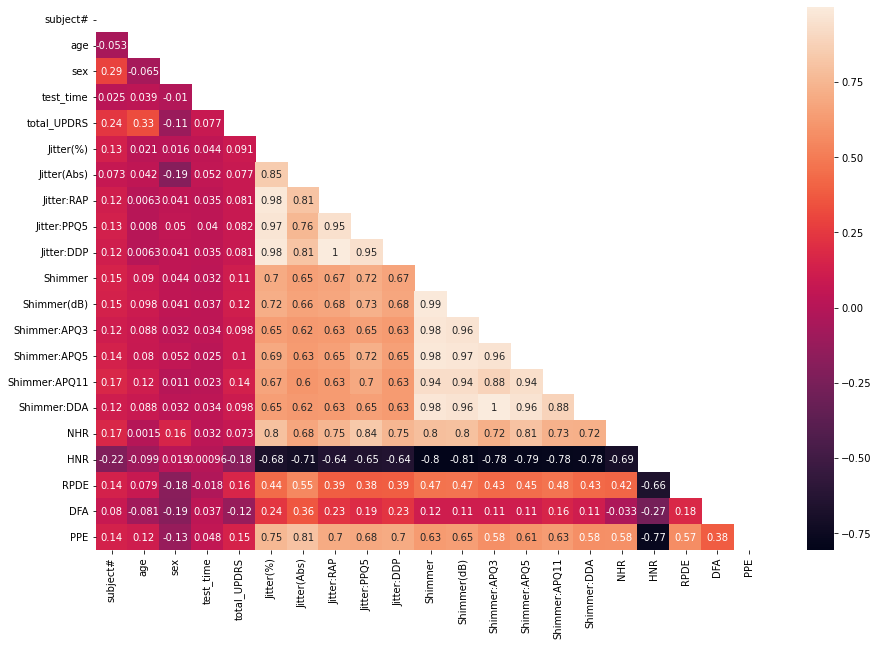

In [ ]:
import numpy as np
f = plt.figure(figsize=(15, 10))
correlation_matrix = np.triu(df.corr())
sns.heatmap(df.corr(),annot = True, mask = correlation_matrix)
#heatmap illustration based on correlation matrix

The heat map suggests correlation greater than 0 for all attributes except those which are between HNR and all other attributes. Also we can see such trend between DFA and age, sex, total_UPDRS, NHR, HNR. RPDE and PPE also have values below 0 with sex and HNR. Although, the most significant correlation is between Shimmer:APQ3 and total_UPDRS and Shimmer:DDA and total_UPDRS.

Examine the pairwise distribution between all columns

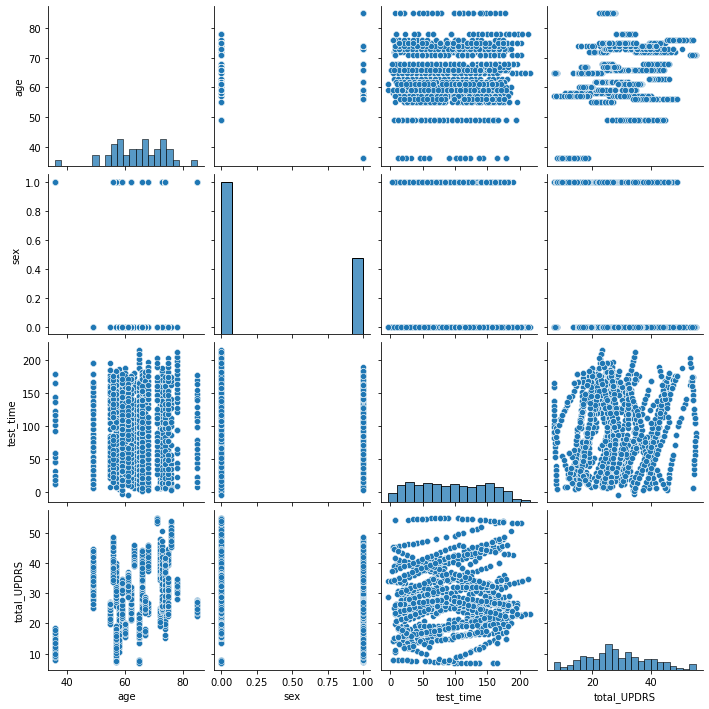

In [ ]:

sns.pairplot(data=df[['age','sex','test_time','total_UPDRS']].dropna())
plt.show()

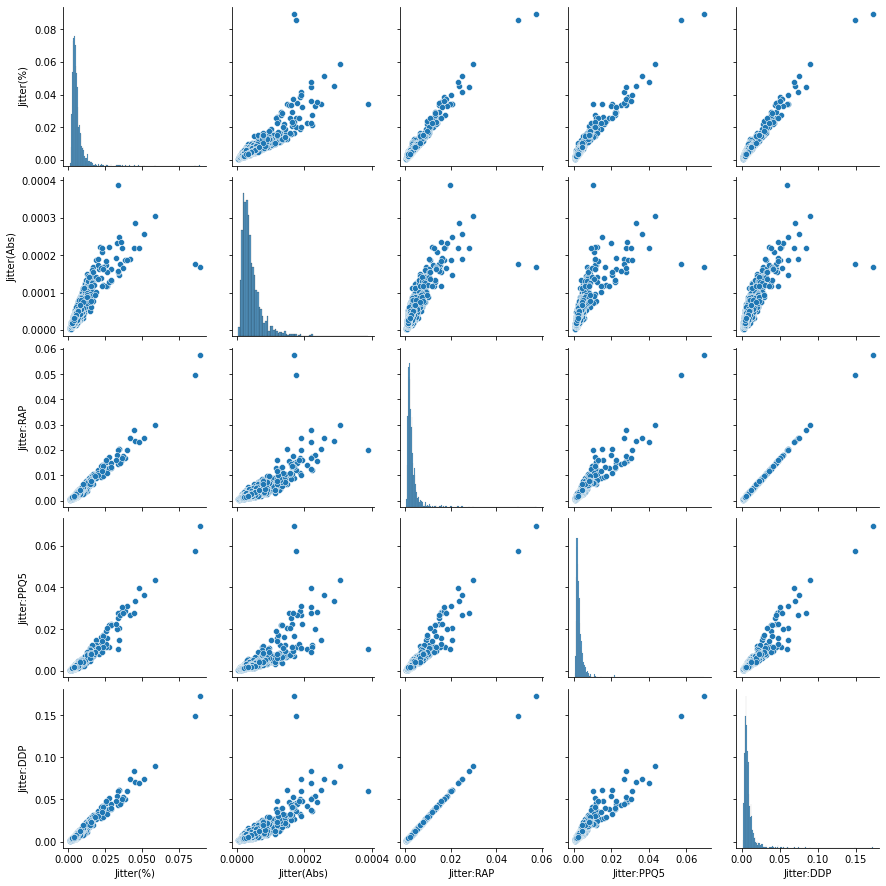

In [ ]:
sns.pairplot(data=df[['Jitter(%)','Jitter(Abs)','Jitter:RAP','Jitter:PPQ5','Jitter:DDP']].dropna())
plt.show()

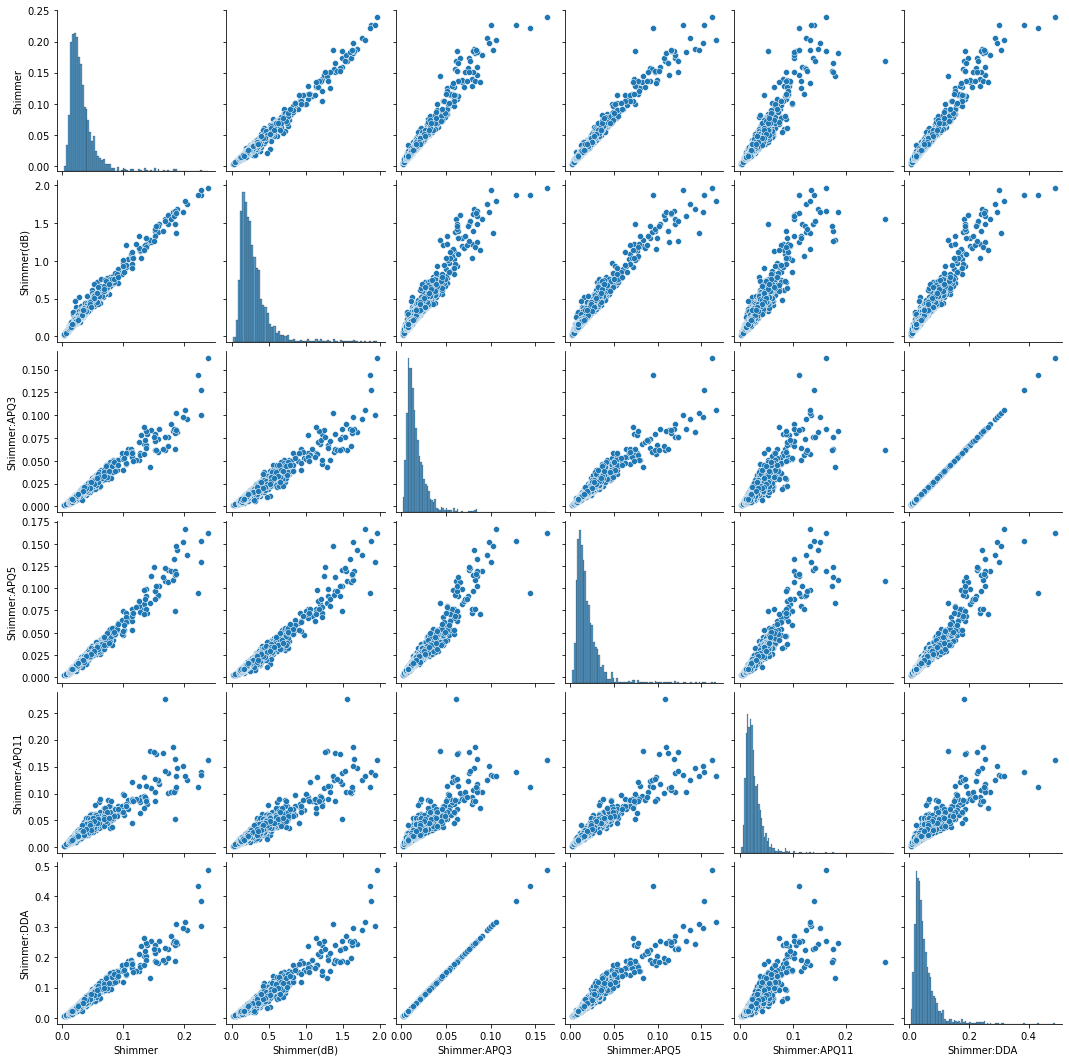

In [ ]:
sns.pairplot(data=df[['Shimmer','Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','Shimmer:APQ11','Shimmer:DDA']].dropna())
plt.show()

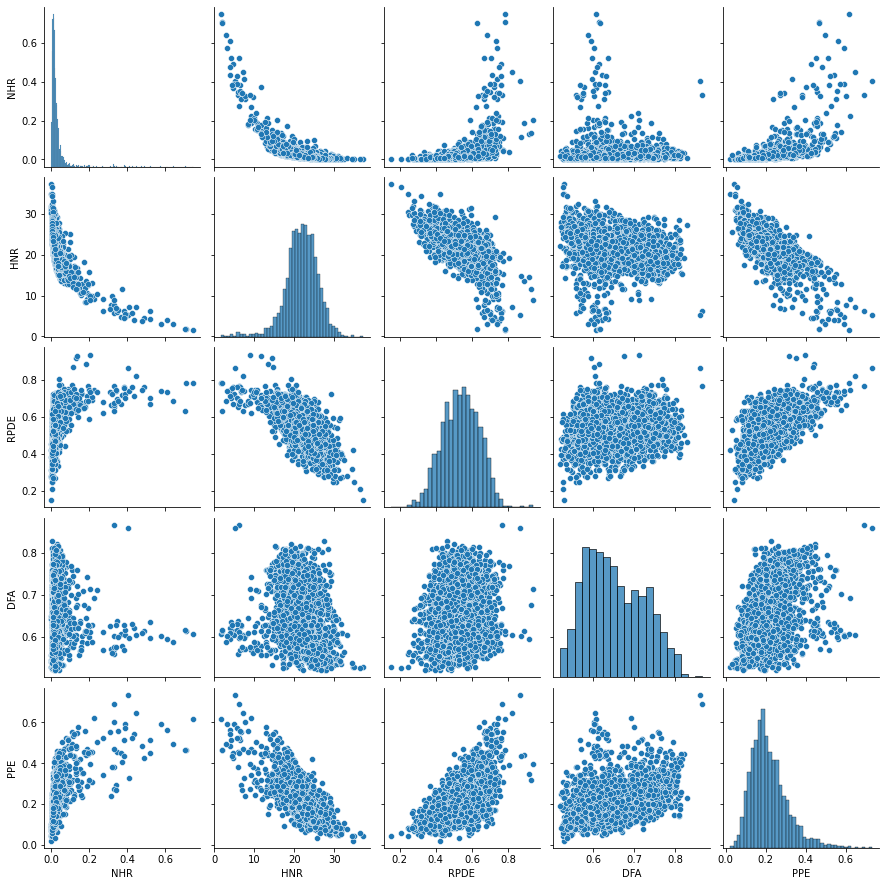

In [ ]:
sns.pairplot(data=df[['P]].dropna())
plt.show()

A pair plot can be overwhelming at first, but it can also let us quickly identify interesting trends which can be examined further.

Quick Examination of Categorical Attributes

In [ ]:
df['sex'].value_counts()

0    1400
1     700
Name: sex, dtype: int64

There are 1400 men and 700 women

In [ ]:
df['sex'].count()

2100

### Distribution Analysis for Numerical Atributes

In [ ]:
pd.set_option('display.max_columns',30)
df.tail()

,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
2095,42,61,0,65.7570,34.657,0.00306,0.000025,0.00140,0.00167,0.00421,0.01811,0.167,0.00805,0.00885,0.01335,0.02416,0.019214,24.689,0.55307,0.57152,0.11229
2096,42,61,0,106.7600,36.029,0.00249,0.000019,0.00124,0.00123,0.00373,0.01460,0.130,0.00775,0.00868,0.01144,0.02326,0.011046,24.737,0.52205,0.57030,0.11601
2097,42,61,0,-4.2597,28.634,0.00352,0.000027,0.00125,0.00169,0.00376,0.01708,0.159,0.00739,0.00914,0.01465,0.02216,0.009635,24.315,0.58904,0.57961,0.16296
2098,42,61,0,115.6500,35.402,0.00769,0.000066,0.00407,0.00425,0.01222,0.01657,0.162,0.00789,0.00892,0.01439,0.02367,0.062794,23.240,0.54095,0.59527,0.15142
2099,42,61,0,156.8200,32.495,0.00387,0.000032,0.00186,0.00213,0.00557,0.02603,0.221,0.01345,0.01573,0.02115,0.04035,0.008337,23.411,0.44308,0.64552,0.17985


array([[<AxesSubplot:title={'center':'subject#'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'test_time'}>,
        <AxesSubplot:title={'center':'total_UPDRS'}>],
       [<AxesSubplot:title={'center':'Jitter(%)'}>,
        <AxesSubplot:title={'center':'Jitter(Abs)'}>,
        <AxesSubplot:title={'center':'Jitter:RAP'}>,
        <AxesSubplot:title={'center':'Jitter:PPQ5'}>,
        <AxesSubplot:title={'center':'Jitter:DDP'}>],
       [<AxesSubplot:title={'center':'Shimmer'}>,
        <AxesSubplot:title={'center':'Shimmer(dB)'}>,
        <AxesSubplot:title={'center':'Shimmer:APQ3'}>,
        <AxesSubplot:title={'center':'Shimmer:APQ5'}>,
        <AxesSubplot:title={'center':'Shimmer:APQ11'}>],
       [<AxesSubplot:title={'center':'Shimmer:DDA'}>,
        <AxesSubplot:title={'center':'NHR'}>,
        <AxesSubplot:title={'center':'HNR'}>,
        <AxesSubplot:title={'center':'RPDE'}>,
        <AxesSubplo

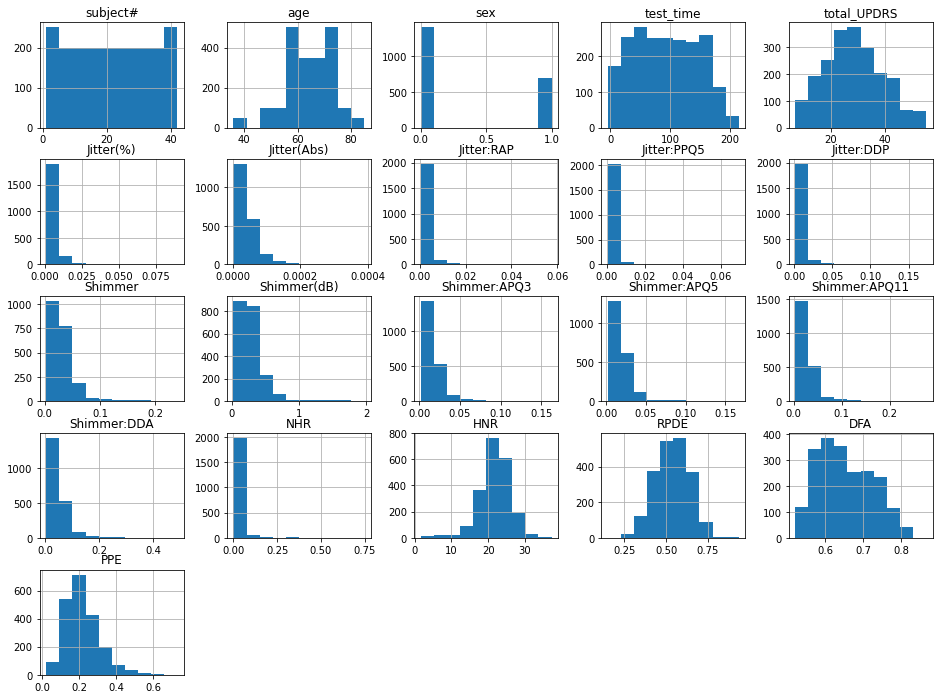

In [ ]:
df.hist(figsize=(16,12))

<AxesSubplot:>

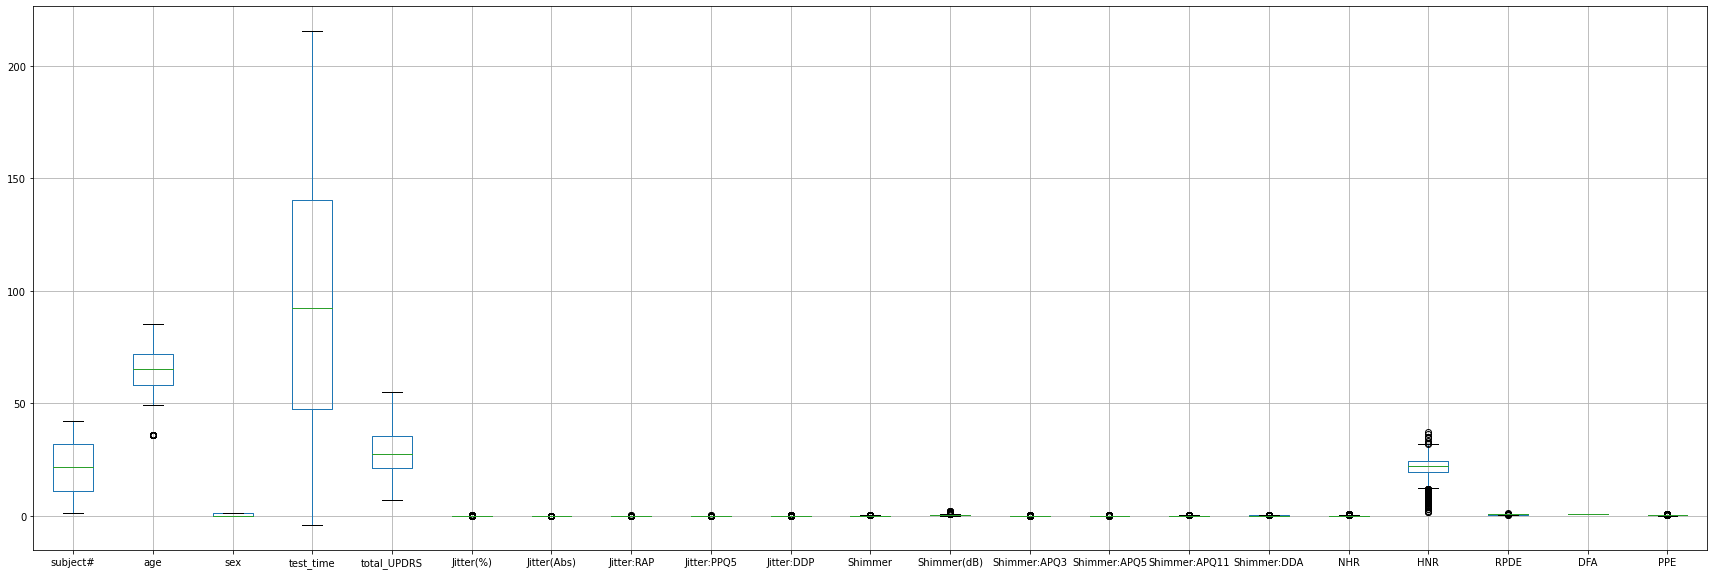

In [ ]:
df.boxplot(figsize=(30,10))
#The provided box plot below demonstrates the number of outliers, which shows that subject, age, test_time, total_UPDRS and HNR have a lot of outliers

<AxesSubplot:>

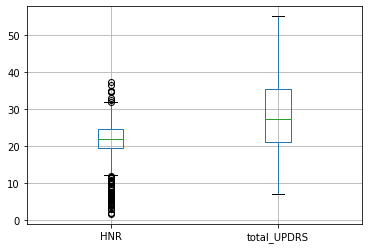

In [ ]:
df[['HNR','total_UPDRS']].boxplot()

<AxesSubplot:>

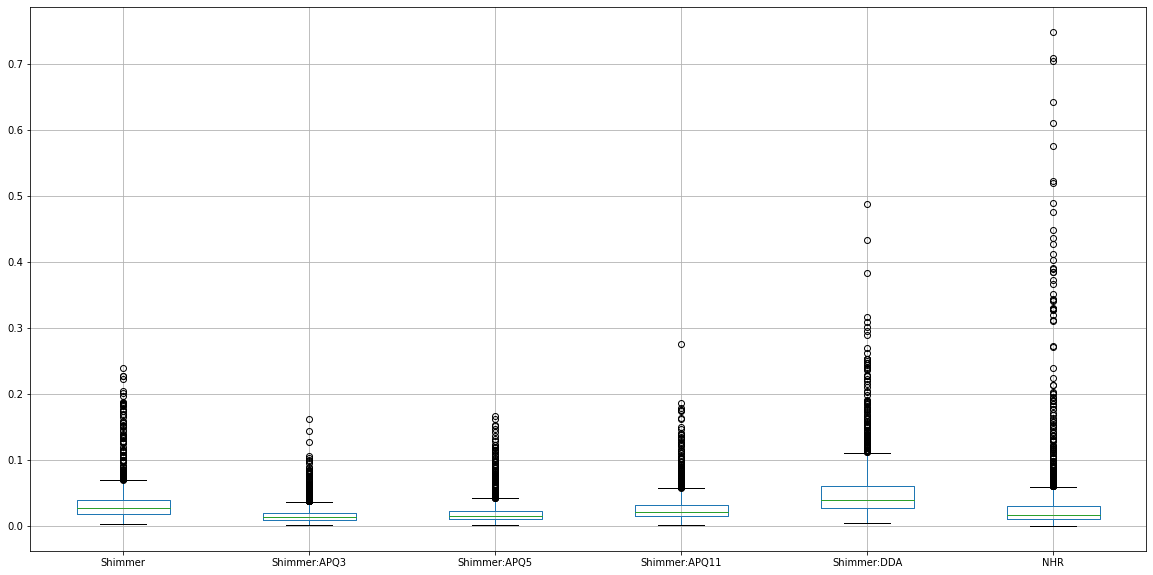

In [ ]:
df[['Shimmer','Shimmer:APQ3','Shimmer:APQ5','Shimmer:APQ11','Shimmer:DDA','NHR']].boxplot(figsize=(20,10))
#Here we can notice that NHR has the highest amount of outliers among other measures.

<AxesSubplot:>

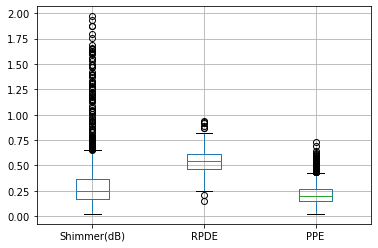

In [ ]:
df[['Shimmer(dB)','RPDE','PPE']].boxplot()

let's examine the relationship between Jitter and Shimmer with a scatter plot.

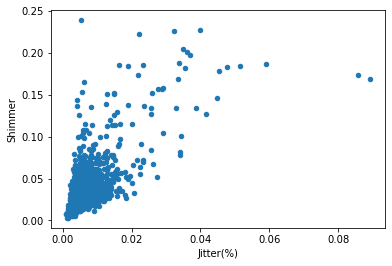

In [ ]:
df.plot.scatter(x='Jitter(%)', y='Shimmer')
plt.show()

Based on this scatter plot we can say that Jitter(%) probably tends to grow linearly as Shimmer grows. We can see the trend clearer with `Seaborn's regplot`, which draws a line that best fits the relation between two numeric attributes.

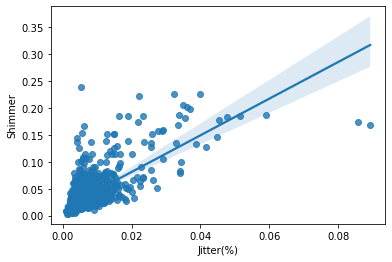

In [ ]:
sns.regplot(data=df, x='Jitter(%)', y='Shimmer')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


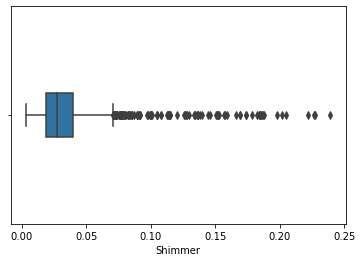

In [ ]:
sns.boxplot(x=df['Shimmer'], orient='v', width=0.2)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


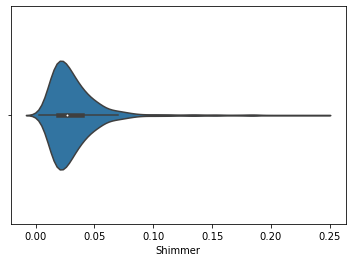

In [ ]:
#Violin plot for Shimmer

sns.violinplot(x=df['Shimmer'], orient='v', width=0.5)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


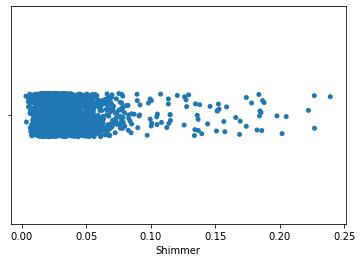

In [ ]:
sns.stripplot(x=df['Shimmer'], jitter=True, orient='v')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 67.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


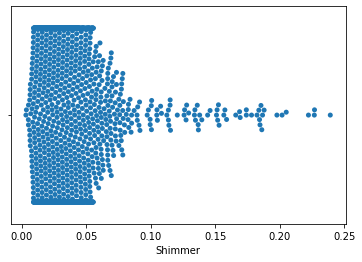

In [ ]:
#Swar mplot for Shimmer

sns.swarmplot(x=df['Shimmer'], orient='v')
plt.show()

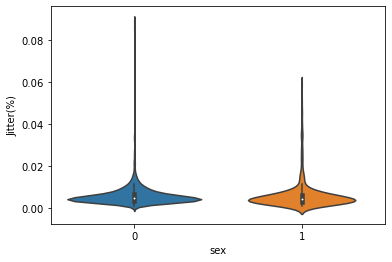

In [ ]:
sns.violinplot(data=df, x='sex', y='Jitter(%)')
plt.show()

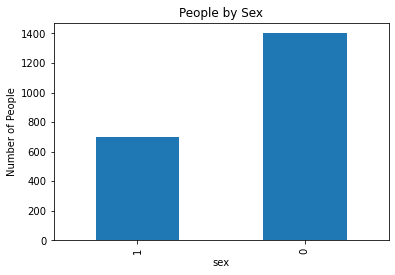

In [ ]:
frequency_table.plot(kind='bar')
plt.xlabel('sex')
plt.ylabel('Number of People')
plt.title('People by Sex')
plt.show()

To sum up, it is possible to conclude that in the range of biomedical voice measurements, there were more men taking part than women. Moreover, in terms of several measures of variation in fundamental frequency, men have higher rates of jitter(%) than women. 
In general, if we compare scores of jitter(%) and shimmer, we can notice that they are directly proportional to each other.
Regarding age, it is possible to note that in this study the main focus was on people aged between 50 and 75. Also, people older than 70 have the highest indexes for total_UPDRS, which shows Clinician's total UPDRS score. And in this context, men tend to have higher total_UPDRS than women. While the most common rate for Jitter lies between 0 and 0.02, for Shimmer it locates in the range of 0 and 0.10. 
Regarding other measures such as NHR, HNR, RPDE, DFA, PPE, first of all, it is obvious that NHR and HNR are inversely proportional, but NHR is directly proportional to RPDE, which describes the relationship between the ratio of noise to tonal components in the voice and nonlinear dynamical complexity measure. Moreover, is it worth noting the direct proportionality of NHR and PPE (A nonlinear measure of fundamental frequency variation)? In all those relationships the most common rates of NHR lies between 0 and 0.2. 
Regarding RPDE, we can easily conclude that it is directly proportional to DFA, and PPE and inversely proportional to HNR. And again, for all those proportionality relationships, the most common rates of RPDE are located in the range of 0.5 and 0.7. 
Furthermore in terms of Several measures of variation in amplitude, Shimmer, Shimmer(dB), Shimmer: APQ3, Shimmer: APQ5, Shimmer: APQ11, Shimmer: DDA all of them have a direct proportionality relationship between each other, and the most common rates of each lie between 0.05 and 0.15. And if we consider several measures of variation in fundamental frequency, Jitter(%), Jitter(Abs), Jitter: RAP, Jitter: PPQ5, Jitter: DDP each of them has the same tendency as we saw in Shimmer, and the most common indexes are in the range of 0.025 and 0.03. 

## **Clustering**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mt
from sklearn import manifold
from sklearn import cluster 
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
pd.options.mode.chained_assignment = None  

In [ ]:
data = np.array(df.values, dtype = float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (2100, 21)


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

Part 1: Data Setup

In [ ]:
colors = np.array(['lightblue', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple', 'tomato', 'gold', 'brown', 'orange', 'red'])
def clustering_scatterplot(points, labels, centers, title):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i],
                        label = 'cluster '+str(i))

    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')
    
def clustering_scatterplotDBSCAN(points, labels, title):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i-1,0],
                        points[labels==i-1,1], 
                        c=colors[i],
                        label = 'cluster '+str(i))

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

Part 2: K-mean clustering

Elbow criterion method

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

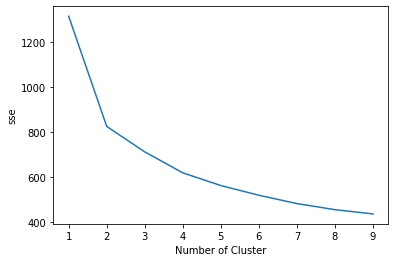

In [ ]:
X = pd.DataFrame(data)
data1 = X
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data1)
    data1["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Cluster")
plt.ylabel("sse")
plt.show()



Silhouette Coefficient Method

In [ ]:
df = pd.read_csv("./parkinson_sample.csv")
X = np.array(df.values, dtype=float)
y = np.array(df.values, dtype=float)
best = 0
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("clusters={}, silhouette coefficient:{}".format(n_cluster, sil_coeff))

clusters=2, silhouette coefficient:0.5277521746778003
clusters=3, silhouette coefficient:0.4174548012873584
clusters=4, silhouette coefficient:0.3376784745014445
clusters=5, silhouette coefficient:0.27678338694869875
clusters=6, silhouette coefficient:0.23272263683274058
clusters=7, silhouette coefficient:0.22745241425862012
clusters=8, silhouette coefficient:0.25212657259758897
clusters=9, silhouette coefficient:0.2403133927525277
clusters=10, silhouette coefficient:0.24768129123451163


It can be seen that the best value of k = 3

In [ ]:
k = 3

In [ ]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

In [ ]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

Multi-dimensional Scaling for clusters = 3

In [ ]:
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete") 

transformation complete


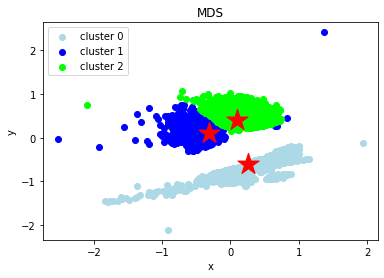

In [ ]:
we clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

t-SNE for 3 clusters

In [ ]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


transformation complete


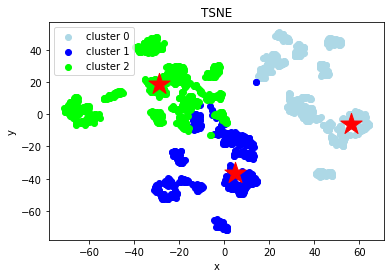

In [ ]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

Isomap for 3 clusters

In [ ]:
XYcoordinates = manifold.Isomap(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


transformation complete


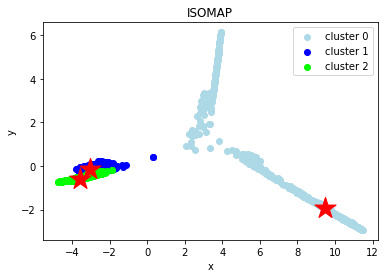

In [ ]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='ISOMAP')

In [ ]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [ ]:
df.head()

,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,cluster
0,1,72,0,25.647,35.810,0.00340,0.000021,0.00178,0.00162,0.00533,...,0.00711,0.00765,0.00926,0.02132,0.016636,25.986,0.42271,0.56963,0.11774,2
1,1,72,0,75.657,39.340,0.00285,0.000013,0.00109,0.00136,0.00327,...,0.00456,0.00584,0.00937,0.01367,0.004981,27.984,0.35842,0.52350,0.17555,2
2,1,72,0,68.688,38.849,0.00340,0.000017,0.00161,0.00174,0.00482,...,0.02120,0.02195,0.03069,0.06360,0.005567,25.399,0.45462,0.56983,0.16291,2
3,1,72,0,61.669,38.353,0.00432,0.000029,0.00156,0.00207,0.00468,...,0.01774,0.02134,0.03451,0.05323,0.013381,22.078,0.51563,0.61864,0.20037,2
4,1,72,0,89.637,40.412,0.00290,0.000014,0.00124,0.00142,0.00371,...,0.00862,0.01156,0.01737,0.02585,0.005320,27.200,0.44967,0.54700,0.18939,2


In [ ]:
df.tail()

,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,cluster
2095,42,61,0,65.7570,34.657,0.00306,0.000025,0.00140,0.00167,0.00421,...,0.00805,0.00885,0.01335,0.02416,0.019214,24.689,0.55307,0.57152,0.11229,1
2096,42,61,0,106.7600,36.029,0.00249,0.000019,0.00124,0.00123,0.00373,...,0.00775,0.00868,0.01144,0.02326,0.011046,24.737,0.52205,0.57030,0.11601,1
2097,42,61,0,-4.2597,28.634,0.00352,0.000027,0.00125,0.00169,0.00376,...,0.00739,0.00914,0.01465,0.02216,0.009635,24.315,0.58904,0.57961,0.16296,1
2098,42,61,0,115.6500,35.402,0.00769,0.000066,0.00407,0.00425,0.01222,...,0.00789,0.00892,0.01439,0.02367,0.062794,23.240,0.54095,0.59527,0.15142,1
2099,42,61,0,156.8200,32.495,0.00387,0.000032,0.00186,0.00213,0.00557,...,0.01345,0.01573,0.02115,0.04035,0.008337,23.411,0.44308,0.64552,0.17985,1


In [ ]:
df.groupby('cluster').mean()

,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
cluster,,,,,,,,,,,,,,,,,,,,,
0,26.500000,63.571429,1.0,92.625482,26.811189,0.006153,0.000034,0.003094,0.003473,0.009282,...,0.319446,0.017515,0.021046,0.027415,0.052545,0.044878,21.862149,0.512519,0.633461,0.200584
1,30.695513,64.985577,0.0,96.556232,34.803090,0.006713,0.000053,0.003196,0.003484,0.009590,...,0.333458,0.018339,0.021494,0.030988,0.055017,0.030231,20.540704,0.574894,0.678227,0.243016
2,9.595361,64.689433,0.0,91.543856,25.023349,0.005374,0.000043,0.002540,0.002759,0.007619,...,0.271550,0.015197,0.017346,0.023695,0.045591,0.020706,22.615143,0.533947,0.648443,0.211909


In [ ]:
df.cluster.value_counts()

2    776
0    700
1    624
Name: cluster, dtype: int64

Conclusion

While the Parkinson dataset seems to be unstructured, clustering can be used to classify those datasets into structures that are easier to be interpreted and manipulated. First, there are a total of 2100 rows which is large, such large number of data making it difficult to analyze and monitor the situation of patients. Thus, clustering can help to group those clusters into three main groups. In each group, the members have similar data, which means that important features of the data can be shown directly, making it a good start for deep analytics. Then, it is difficult to know the number of classes in the dataset as there are 21 attributes and with manual calculation, it is difficult to find a similar dataset as the values are similar. Therefore, it is difficult to know, whether it is two, three, or four. Moreover, outliers can be found in the data when using clustering. Clustering can serve as an identifier for outliers. During visualization, outliers can be shown in the graph. For example, there are some outliers in cluster 2. At the same time, clustering can be used to find the separate cluster that is closely packed and positioned. 

## **Data Preparation**

In [ ]:
print('Mean age: ',df.age.mean())
print('Median age: ',df.age.median())

Mean age:  64.4047619047619
Median age:  65.0


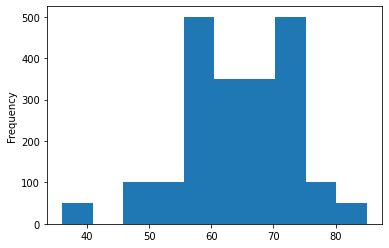

In [ ]:
df.age.plot.hist()

In [ ]:
print('Mean jitter(%): ',df['Jitter(%)'].mean())
print('Median jitter(%): ',df['Jitter(%)'].median())

Mean jitter(%):  0.006031314285714273
Median jitter(%):  0.00477


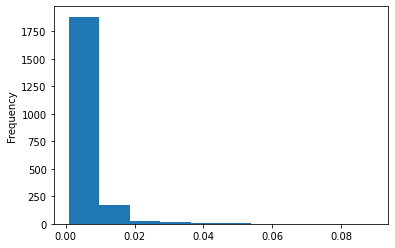

In [ ]:
df['Jitter(%)'].plot.hist()

In [ ]:
print('Mean NHR: ',df['NHR'].mean())
print('Median NHR: ',df['NHR'].median())

Mean NHR:  0.031593550952380936
Median NHR:  0.017671


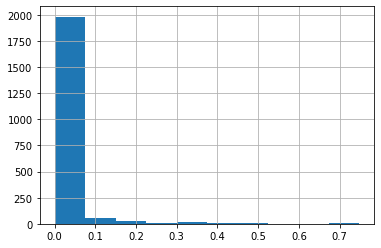

In [ ]:
df.NHR.hist()

In [ ]:
df.columns[df.isna().any()]

Index([], dtype='object')

In [ ]:
df.head()

,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,25.647,35.810,0.00340,0.000021,0.00178,0.00162,0.00533,...,0.157,0.00711,0.00765,0.00926,0.02132,0.016636,25.986,0.42271,0.56963,0.11774
1,1,72,0,75.657,39.340,0.00285,0.000013,0.00109,0.00136,0.00327,...,0.089,0.00456,0.00584,0.00937,0.01367,0.004981,27.984,0.35842,0.52350,0.17555
2,1,72,0,68.688,38.849,0.00340,0.000017,0.00161,0.00174,0.00482,...,0.316,0.02120,0.02195,0.03069,0.06360,0.005567,25.399,0.45462,0.56983,0.16291
3,1,72,0,61.669,38.353,0.00432,0.000029,0.00156,0.00207,0.00468,...,0.371,0.01774,0.02134,0.03451,0.05323,0.013381,22.078,0.51563,0.61864,0.20037
4,1,72,0,89.637,40.412,0.00290,0.000014,0.00124,0.00142,0.00371,...,0.173,0.00862,0.01156,0.01737,0.02585,0.005320,27.200,0.44967,0.54700,0.18939


Rescaling features

In [ ]:
from sklearn.preprocessing import RobustScaler
no_outliers = ['age','subject#','test_time','tital_UPDRS','sex','DFA']
robust_scaler = RobustScaler()
df[df.columns[~df.columns.isin(no_outliers)]] = robust_scaler.fit_transform(df[df.columns[~df.columns.isin(no_outliers)]])

In [ ]:
df.head()

,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,25.647,0.601901,-0.435959,-0.419408,-0.248154,-0.481928,-0.247909,...,-0.468750,-0.554751,-0.614072,-0.757571,-0.555027,-0.051762,0.802244,-0.799750,0.56963,-0.740994
1,1,72,0,75.657,0.849061,-0.610979,-0.652961,-0.655835,-0.638554,-0.653222,...,-0.822917,-0.778582,-0.754410,-0.751134,-0.778793,-0.634643,1.202565,-1.234502,0.52350,-0.221318
2,1,72,0,68.688,0.814683,-0.435959,-0.524671,-0.348597,-0.409639,-0.348254,...,0.359375,0.682028,0.494670,0.496562,0.681682,-0.605336,0.684632,-0.583963,0.56983,-0.334944
3,1,72,0,61.669,0.779954,-0.143198,-0.156250,-0.378139,-0.210843,-0.375799,...,0.645833,0.378319,0.447374,0.720117,0.378355,-0.214548,0.019235,-0.171392,0.61864,0.001798
4,1,72,0,89.637,0.924119,-0.595068,-0.620066,-0.567208,-0.602410,-0.566650,...,-0.385417,-0.422208,-0.310913,-0.282955,-0.422523,-0.617689,1.045482,-0.617437,0.54700,-0.096905


In [ ]:
for column in df.columns:
    if column in no_outliers:
       df[column] = df[column]/max(df[column])
df.head()

,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,0.02381,0.847059,0.0,0.119017,0.601901,-0.435959,-0.419408,-0.248154,-0.481928,-0.247909,...,-0.468750,-0.554751,-0.614072,-0.757571,-0.555027,-0.051762,0.802244,-0.799750,0.658075,-0.740994
1,0.02381,0.847059,0.0,0.351093,0.849061,-0.610979,-0.652961,-0.655835,-0.638554,-0.653222,...,-0.822917,-0.778582,-0.754410,-0.751134,-0.778793,-0.634643,1.202565,-1.234502,0.604783,-0.221318
2,0.02381,0.847059,0.0,0.318753,0.814683,-0.435959,-0.524671,-0.348597,-0.409639,-0.348254,...,0.359375,0.682028,0.494670,0.496562,0.681682,-0.605336,0.684632,-0.583963,0.658306,-0.334944
3,0.02381,0.847059,0.0,0.286180,0.779954,-0.143198,-0.156250,-0.378139,-0.210843,-0.375799,...,0.645833,0.378319,0.447374,0.720117,0.378355,-0.214548,0.019235,-0.171392,0.714695,0.001798
4,0.02381,0.847059,0.0,0.415968,0.924119,-0.595068,-0.620066,-0.567208,-0.602410,-0.566650,...,-0.385417,-0.422208,-0.310913,-0.282955,-0.422523,-0.617689,1.045482,-0.617437,0.631932,-0.096905


Treating Outleris

In [ ]:
for i in df.columns:
  print('min',i,': ',min(df[i]))

min subject# :  0.023809523809523808
min age :  0.4235294117647059
min sex :  0.0
min test_time :  -0.019780500255232262
min total_UPDRS :  -1.4152882073902917
min Jitter(%) :  -1.2315035799522676
min Jitter(Abs) :  -1.018092105263158
min Jitter:RAP :  -1.0635155096011817
min Jitter:PPQ5 :  -1.1867469879518073
min Jitter:DDP :  -1.05853418593212
min Shimmer :  -1.1576527525710831
min Shimmer(dB) :  -1.1510416666666667
min Shimmer:APQ3 :  -1.0375246872942725
min Shimmer:APQ5 :  -1.0567939523163403
min Shimmer:APQ11 :  -1.1537673738112657
min Shimmer:DDA :  -1.037074954296161
min NHR :  -0.868545422720112
min HNR :  -4.071929473051493
min RPDE :  -2.637013744484455
min DFA :  0.6004736598890942
min PPE :  -1.6017888846439092


In [ ]:
for i in df.columns:
  if i in df[df.columns[~df.columns.isin(no_outliers)]]:
     df[i] = np.log(df[i]+(1.01-min(df[i])))

In [ ]:
for i in df.columns:
  print('min',i,': ',min(df[i]))

min subject# :  0.023809523809523808
min age :  0.4235294117647059
min sex :  0.0
min test_time :  -0.019780500255232262
min total_UPDRS :  0.009950330853168092
min Jitter(%) :  0.009950330853167872
min Jitter(Abs) :  0.009950330853168312
min Jitter:RAP :  0.009950330853168092
min Jitter:PPQ5 :  0.009950330853168312
min Jitter:DDP :  0.009950330853168092
min Shimmer :  0.009950330853168092
min Shimmer(dB) :  0.009950330853168092
min Shimmer:APQ3 :  0.009950330853167872
min Shimmer:APQ5 :  0.009950330853167872
min Shimmer:APQ11 :  0.009950330853167872
min Shimmer:DDA :  0.009950330853168092
min NHR :  0.009950330853168312
min HNR :  0.009950330853167872
min RPDE :  0.009950330853167872
min DFA :  0.6004736598890942
min PPE :  0.009950330853167872


## **Predictive Modeling**

In [ ]:
y = df['total_UPDRS']
X = df.drop('total_UPDRS', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
"""from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
print("Score: ",model.score(X_test,y_test))"""

'from sklearn import linear_model\nlm = linear_model.LinearRegression()\nmodel = lm.fit(X_train,y_train)\nprint("Score: ",model.score(X_test,y_test))'

In [ ]:
"""import xgboost as xgb
xgbr = xgb.XGBRegressor(verbosity=0)
print(xgbr)
xgbr.fit(X_train, y_train)
print("Score: ",xgbr.score(X_test,y_test))"""

'import xgboost as xgb\nxgbr = xgb.XGBRegressor(verbosity=0)\nprint(xgbr)\nxgbr.fit(X_train, y_train)\nprint("Score: ",xgbr.score(X_test,y_test))'

In [ ]:
#%pip install catboost

In [ ]:
"""
RANDOM_SEED = 42 
model = CatBoostRegressor(iterations = 5000, random_seed = RANDOM_SEED, eval_metric='MAPE', 
                          custom_metric=['R2', 'MAE'], silent=True)"""

"from catboost import CatBoostRegressor\nRANDOM_SEED = 42 \nmodel = CatBoostRegressor(iterations = 5000, random_seed = RANDOM_SEED, eval_metric='MAPE', \n                          custom_metric=['R2', 'MAE'], silent=True)"

In [ ]:
"""model.fit(X_train, y_train,   eval_set=(X_test, y_test),
     verbose_eval=0,
     use_best_model=True,
     plot=True
     )
print("Score:", model.score(X_test, y_test))"""

'model.fit(X_train, y_train,   eval_set=(X_test, y_test),\n     verbose_eval=0,\n     use_best_model=True,\n     plot=True\n     )\nprint("Score:", model.score(X_test, y_test))'

In [ ]:
#preprocess_pipeline = make_pipeline(StandardScaler())

In [ ]:
#preprocess_pipeline = make_pipeline(RobustScaler())

Random Forest Pipeline

In [ ]:
pipe = Pipeline(steps=[#('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.922:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 8}


Linear Regression Pipeline

In [ ]:
pipe = Pipeline(steps=[#('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
#NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        #'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        #'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.218:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=11), 'reduce_dim__n_components': 11}


XGBoost Regressor

In [ ]:
import xgboost as xgb
pipe = Pipeline(steps=[#('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', xgb.XGBRegressor(verbosity=0))])


In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
XGB_best_params = search.best_params_
XGB_best_model = search.best_estimator_

Best CV score = 0.925:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 6}


CatBoost Regressor

In [ ]:
from catboost import CatBoostRegressor
pipe = Pipeline(steps=[#('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', CatBoostRegressor())])

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
CB_best_params = search.best_params_
CB_best_model = search.best_estimator_

Learning rate set to 0.04444
0:	learn: 0.3118623	total: 1.02ms	remaining: 1.02s
1:	learn: 0.3060752	total: 2ms	remaining: 997ms
2:	learn: 0.3006764	total: 2.82ms	remaining: 938ms
3:	learn: 0.2963800	total: 3.88ms	remaining: 965ms
4:	learn: 0.2912101	total: 4.87ms	remaining: 969ms
5:	learn: 0.2872800	total: 5.84ms	remaining: 967ms
6:	learn: 0.2840664	total: 6.85ms	remaining: 971ms
7:	learn: 0.2798147	total: 7.86ms	remaining: 975ms
8:	learn: 0.2765269	total: 8.83ms	remaining: 972ms
9:	learn: 0.2733182	total: 9.79ms	remaining: 969ms
10:	learn: 0.2688311	total: 10.7ms	remaining: 965ms
11:	learn: 0.2644106	total: 11.8ms	remaining: 968ms
12:	learn: 0.2604095	total: 12.8ms	remaining: 968ms
13:	learn: 0.2569335	total: 13.7ms	remaining: 965ms
14:	learn: 0.2543525	total: 14.7ms	remaining: 968ms
15:	learn: 0.2511749	total: 15.8ms	remaining: 972ms
16:	learn: 0.2481501	total: 16.9ms	remaining: 977ms
17:	learn: 0.2450417	total: 17.9ms	remaining: 975ms
18:	learn: 0.2413293	total: 18.8ms	remaining: 97

The results suggest that XGBoost Regressor method is better. Thus, we will probably choose XGBoost model. However, we still need to confirm it by comparing regression models on test set. Let's see the result and then have a conclusion.

**Compare Regression Models on Test Set**

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

mean squared error (MSE)
mean absolute error (MAE)
1-relative squared error (R2)
to choose the better regressor for our problem.

In [ ]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [ ]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
XGB_mse, XGB_mae, XGB_r2 = evaluate_model(X_test, y_test, XGB_best_model)
CB_mse, CB_mae, CB_r2 = evaluate_model(X_test, y_test, CB_best_model)

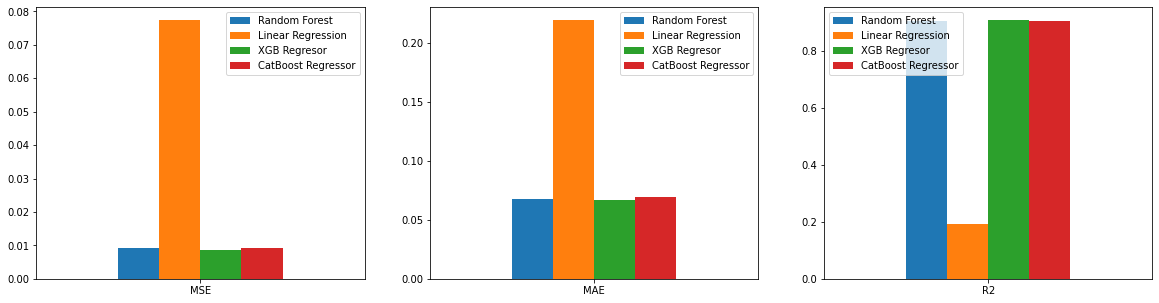

In [ ]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse,'XGB Regresor':XGB_mse,'CatBoost Regressor':CB_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae,'XGB Regresor':XGB_mae,'CatBoost Regressor': CB_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2,'XGB Regresor':XGB_r2,'CatBoost Regressor': CB_r2}, index=['R2'])


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

    
plt.show()

In [ ]:
print(df_mse)
print('\n\n',df_mae)
print("\n\n",df_r2)

     Random Forest  Linear Regression  XGB Regresor  CatBoost Regressor
MSE        0.00918           0.077451      0.008701            0.009103


      Random Forest  Linear Regression  XGB Regresor  CatBoost Regressor
MAE       0.067173           0.219168      0.066837            0.069299


     Random Forest  Linear Regression  XGB Regresor  CatBoost Regressor
R2       0.904402           0.193429      0.909385            0.905201


So, this tests confirms that XGBoost is the better regression model with lower Mean Square Error and Mean Absolute Error and higher coefficient of determination, despite the fact that the difference are very small we can still claim that XGBoost regression model is better than other models in this case. Therefore, we will choose XGBoost Regressor.

In [ ]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(XGB_best_params.get('reduce_dim'),
                     xgb.XGBRegressor(verbosity=0,**transform(XGB_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [ ]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))